 ## Check Data

In [1]:
import obspy
import matplotlib.pyplot as plt

from obspy.clients.filesystem.sds import Client

### Configurations

In [2]:
config = {}

## Kermadec M7.0 Event
# config['tbeg'] = obspy.UTCDateTime("2023-03-16 00:50")
# config['tend'] = obspy.UTCDateTime("2023-03-16 03:30")

## PNG M7.0 Event
# config['tbeg'] = obspy.UTCDateTime("2023-04-02 18:00")
# config['tend'] = obspy.UTCDateTime("2023-04-02 20:30")

## Local Event
# config['tbeg'] = obspy.UTCDateTime("2023-04-02 20:00")
# config['tend'] = obspy.UTCDateTime("2023-04-02 20:30")

## Local Noise
config['tbeg'] = obspy.UTCDateTime("2023-04-08 00:00")
config['tend'] = obspy.UTCDateTime("2023-04-08 03:00")


config['client'] = Client("/import/freenas-ffb-01-data/ModalAnalysis/data/SDS")

config['seed'] = "XX.RY??..HH*"

config['stations'] = ['RY01','RY02','RY03','RY04','RY05','RY06','RY07','RY08','RY09','RY10']

config['inventories'] = "/import/freenas-ffb-01-data/ModalAnalysis/data/StationXML/"

config['fmin'] = 0.01
config['fmax'] = 80.0

### Load Data

In [3]:
def __get_data_all(config):

    net, sta, loc, cha = config['seed'].split(".")

    st0 = obspy.Stream()

    for sta in config['stations']:

        try:
            st = config['client'].get_waveforms(network=net, station=sta, location=loc, channel=cha, 
                                                starttime=config['tbeg'], endtime=config['tend'])

            if len(st) == 0:
                raise "no data in stream"

            inv = obspy.read_inventory(config['inventories']+f"XX.{sta}.xml")


            st = st.remove_response(inventory=inv, output="VEL", water_level=60, plot=False) 

            st.merge()

            st0 += st

        except:
            print(f" -> loading failed for: {sta}")

    return st0

In [4]:
st0 = __get_data_all(config)

 -> loading failed for: RY10


In [5]:
print(st0.__str__(extended=True))

27 Trace(s) in Stream:
XX.RY01..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY01..HHN | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY01..HHZ | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY02..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY02..HHN | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY02..HHZ | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY03..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY03..HHN | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY03..HHZ | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY04..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000

### Processing

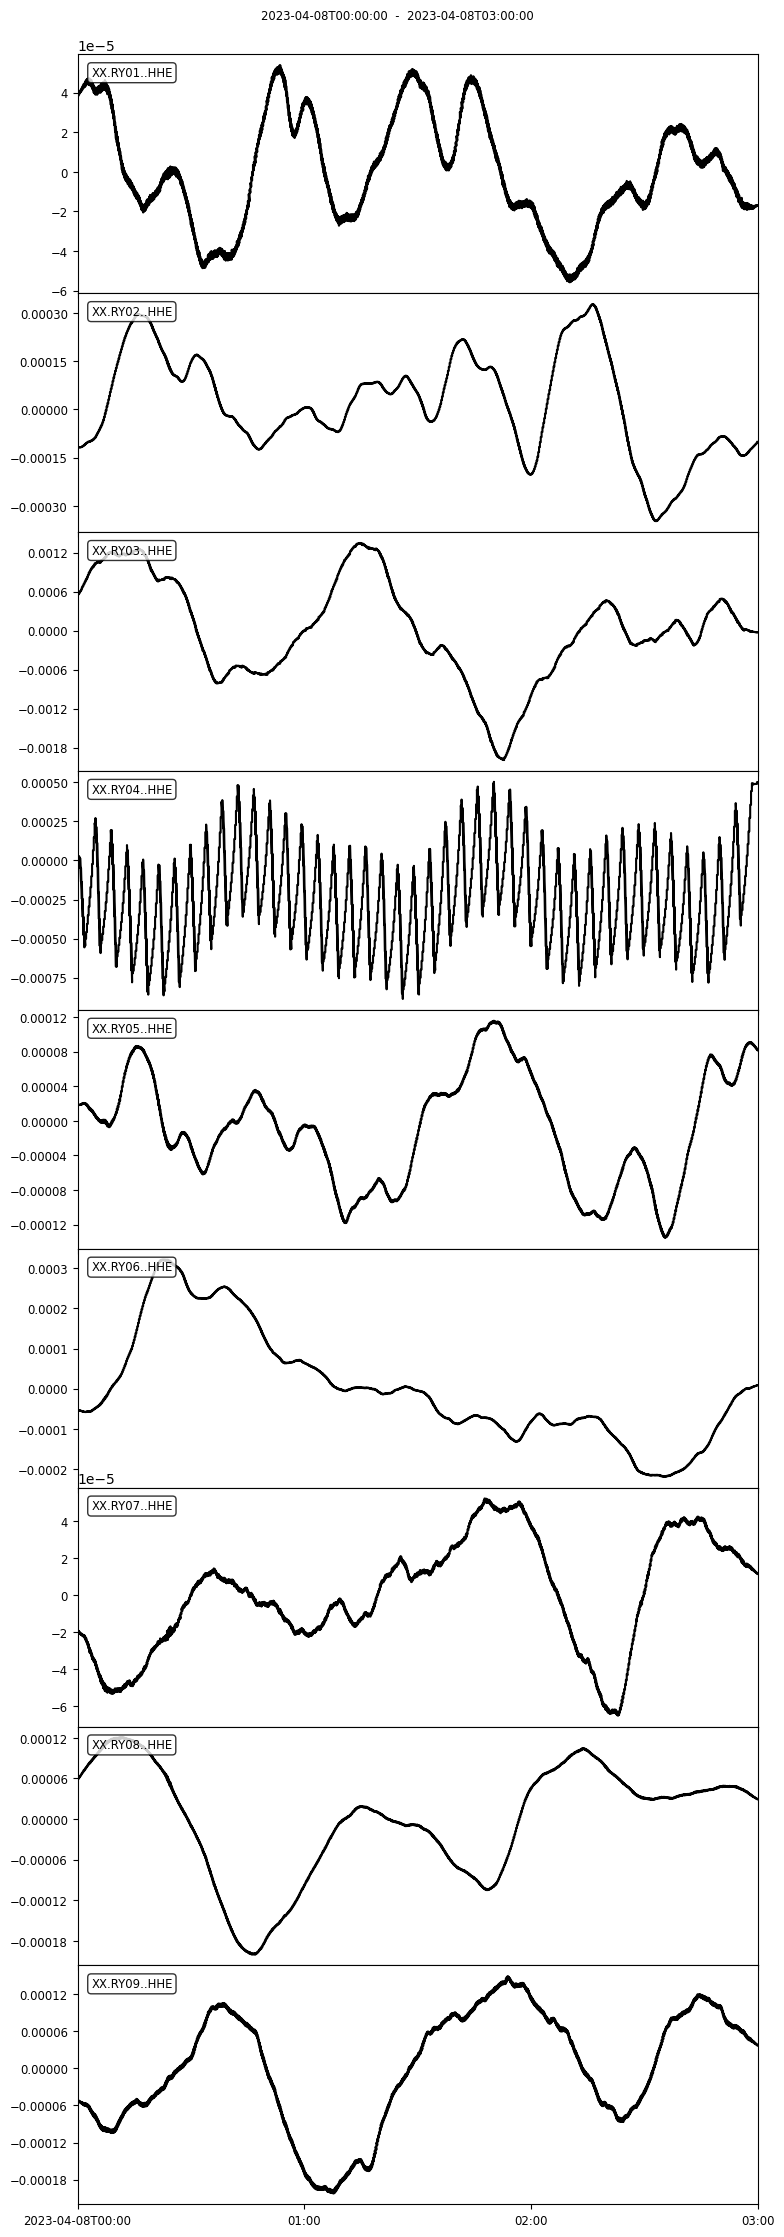

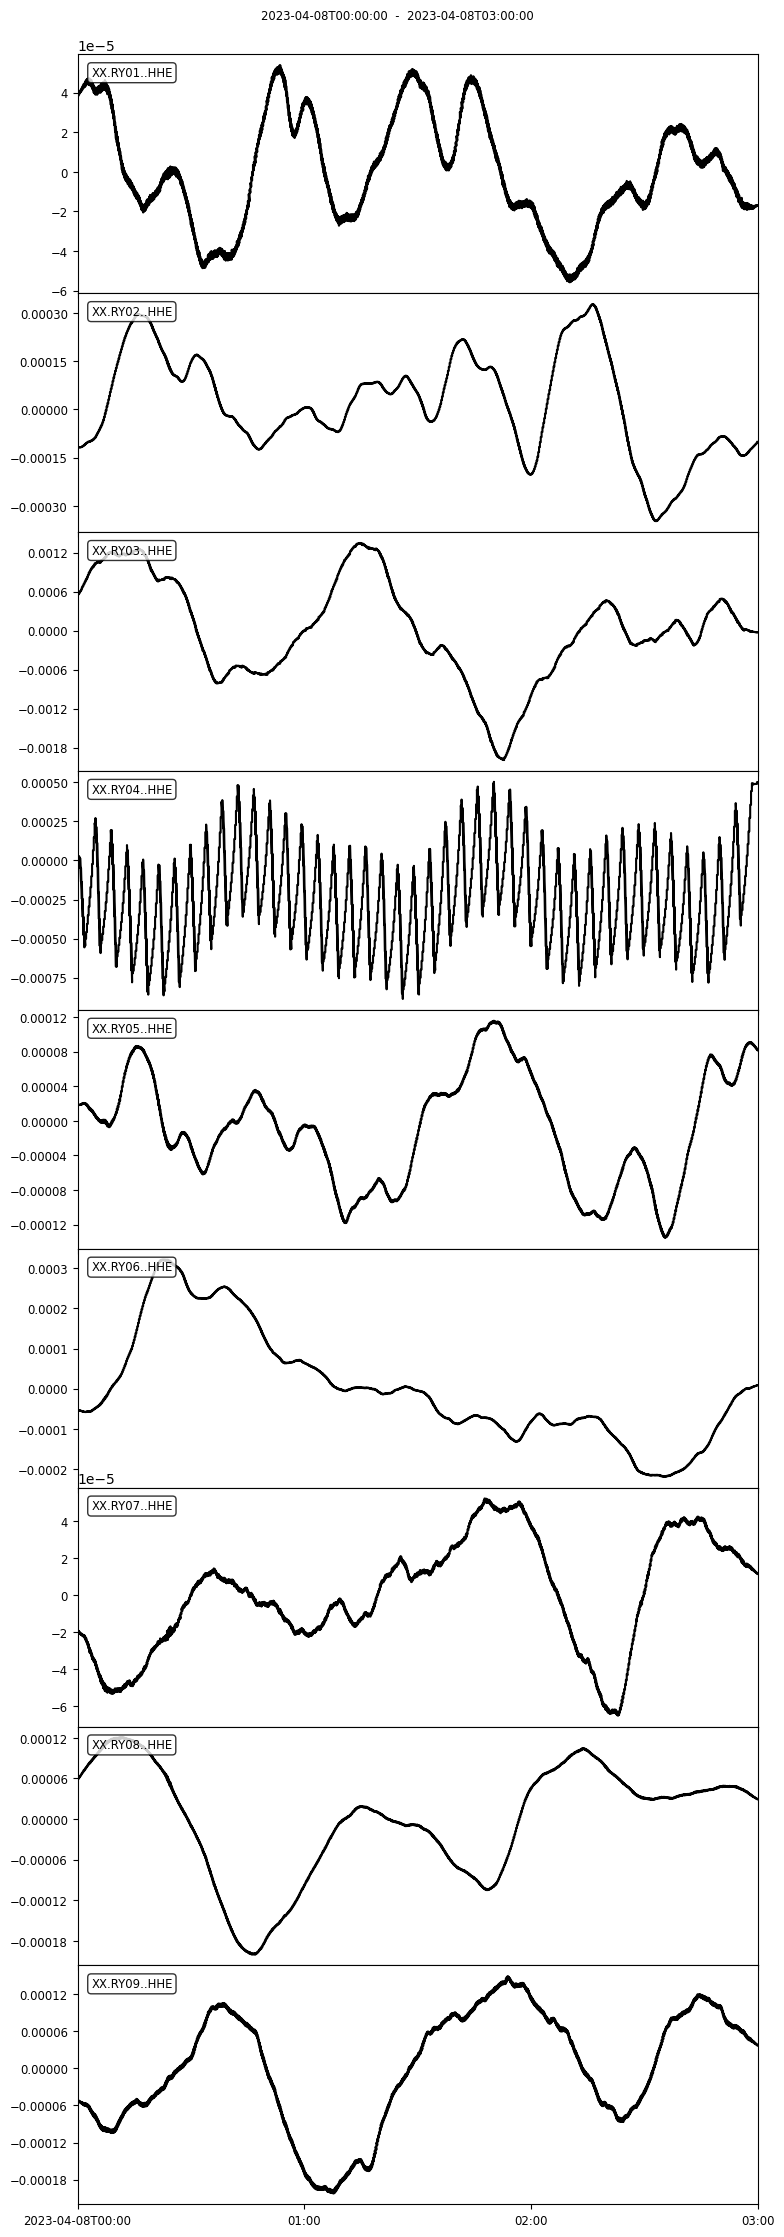

In [6]:
st0 = st0.merge()
st0.select(channel="*E").plot(equal_scale=False)

In [7]:
st = st0.copy()

st = st.detrend('demean')

st = st.taper(0.1)

st = st.filter('bandpass', freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

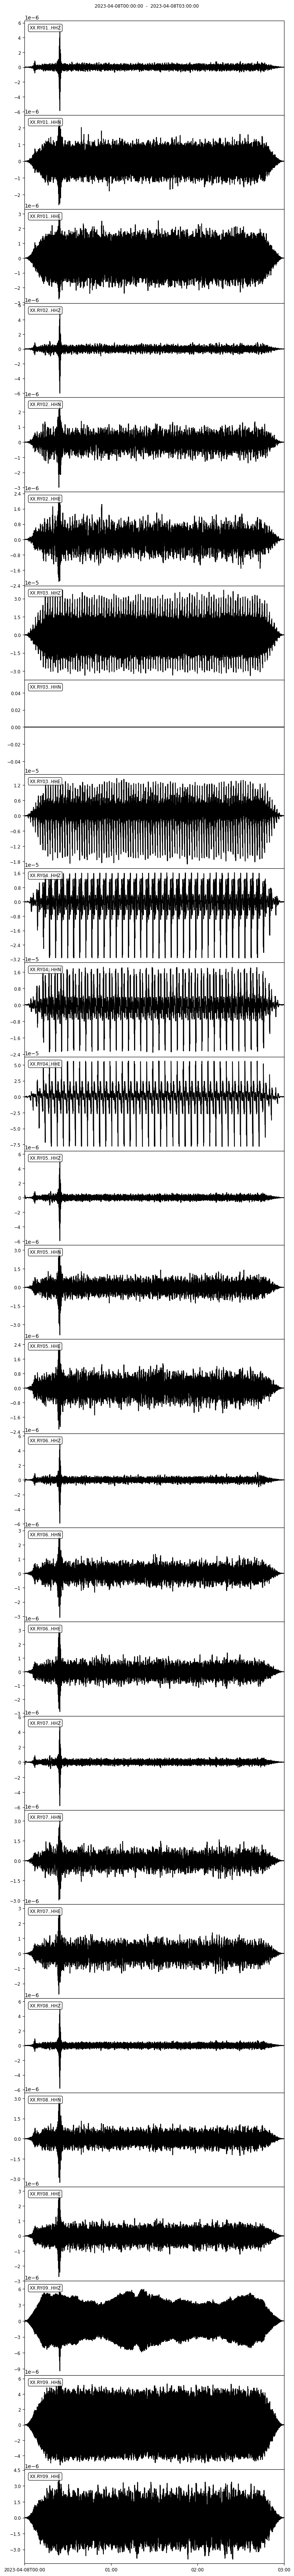

In [8]:
st.plot(equal_scale=False);

### Coherence

In [9]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("BGR")

    net, sta, loc, cha = seed.split(".")


    ## querry inventory data
    try:
        inventory = client.get_stations(network=net,
                                         station=sta,
                                         starttime=tbeg-60,
                                         endtime=tend+60,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None


    ## querry waveform data
    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha,
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None

    waveform.remove_response(inventory=inventory, output="VEL", plot=False)

    return waveform, inventory

In [10]:
fur0, fur_inv = __request_data("GR.FUR..HH*", config['tbeg'], config['tend'])

In [11]:
fur = fur0.copy()
fur = fur.detrend('demean')
fur = fur.taper(0.1)
fur = fur.filter('bandpass', freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
fur = fur.trim(config['tbeg'], config['tend'])

/home/brotzer/anaconda3/envs/pyoma/lib/python3.8/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (80.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)


In [12]:
from andbro__compute_coherence_stream import __coherence_stream

In [13]:
st_sel = st.copy()

## if fur is reference
# st_sel = st_sel.resample(100)
# st_sel += fur

st_sel = st_sel.select(channel="*E")

st_sel = st_sel.remove(st_sel.select(station="RY03")[0])

st_sel = st_sel.normalize(global_max=False)

print(st_sel)

8 Trace(s) in Stream:
XX.RY01..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY02..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY04..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY05..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY06..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY07..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY08..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples
XX.RY09..HHE | 2023-04-08T00:00:00.000000Z - 2023-04-08T03:00:00.000000Z | 200.0 Hz, 2160001 samples


In [23]:
ff, coh = __coherence_stream(st_sel, st_sel.select(station="RY01")[0], nseg=st_sel[0].stats.sampling_rate*5, nover=50)

In [24]:
def __makeplot_coherence(st_in, ff, coh, ref):


    st_ref = st_in.select(station=ref)

    NN = 2
    font = 14
    time_scaling, time_unit = 1/60, "min"

    fig, ax = plt.subplots(NN , 1, figsize=(15,8), gridspec_kw={'height_ratios': [1, 3]})

    ax[0].plot(st_ref[0].times()*time_scaling, st_ref[0].data, color="k", label=st_ref[0].stats.station+"."+st_ref[0].stats.channel)

    for f, c, tr in zip(ff, coh, st_in):
        if tr.stats.station == ref:
            ax[1].plot(f[1:-10], c[1:-10]*100, color="k", zorder=0, ls="-.", label=tr.stats.station+"."+tr.stats.channel)
        else:
            ax[1].plot(f[1:-10], c[1:-10]*100, label=tr.stats.station+"."+tr.stats.channel, alpha=0.8)

    ax[0].legend(fontsize=font-2)
    ax[1].legend(fontsize=font-2)

    ax[1].set_xscale("log")

    ax[1].set_xlim(config['fmin'], config['fmax'])

    ax[1].grid(ls=":", color="grey", zorder=-1, which="both")

#     ax[1].ticklabel_format(axis="y", useOffset=False, style='plain')

    ax[0].set_ylabel(f"norm. Amp. \n (m/s)", fontsize=font)
    ax[0].set_xlabel(f"Time ({time_unit})", fontsize=font)
    ax[1].set_ylabel(f"Coherence (%)", fontsize=font)
    ax[1].set_xlabel(f"Frequency (Hz)", fontsize=font)

    plt.show();

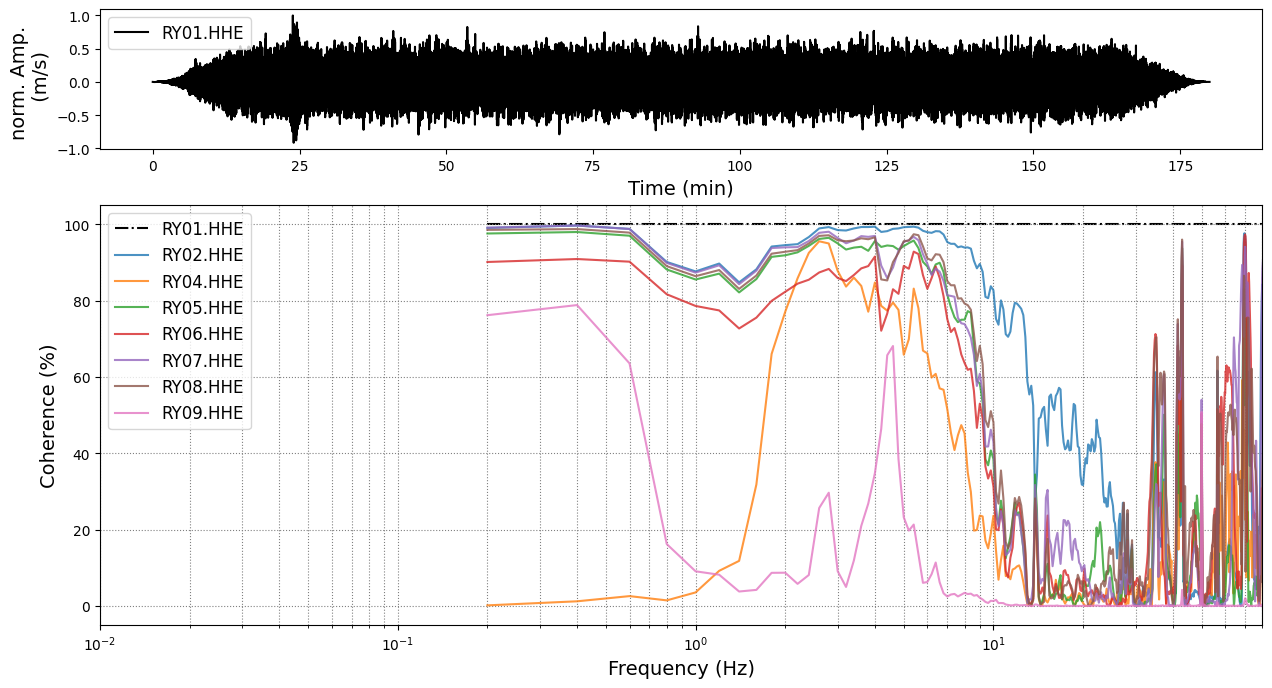

In [25]:
__makeplot_coherence(st_sel, ff, coh, "RY01")

## Cross Wavelet Transform

In [33]:
# %load /home/brotzer/notebooks/BSPF/functions/compute_cross_wavelet_transform.py
def __compute_cross_wavelet_transform(times, arr1, arr2, tdelta, xwt_threshold = 0.1, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, ones, nan_to_num
    import matplotlib.pyplot as plt

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask

    def __mask_smaller_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < thres:
                    mask[k,l] = fill
        return mask

    def __mask_bigger_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] > thres:
                    arr2d[k,l], mask[k,l] = fill
        return mask

    def __mask_unequal_threshold(arr2d, thres, fill=nan, tolerance=0):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < (thres-tolerance) or arr2d[k,l] > (thres+tolerance):
                    mask[k,l] = fill
        return mask

    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## normalize, if desired
    if normalize:
        arr1 /= nanmax(abs(arr1))
        arr2 /= nanmax(abs(arr2))

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)

    ## compute cross-wavelet transform
    xwt, cone_p, ff_xwt, d = xwt(
                                arr1,
                                arr2,
                                dt=dt,
                                dj=dj_set, #0.05,
                                s0=s0_set, #-1,
                                J=J_set, #-1,
                                significance_level=significance_threshold,
                                wavelet=mother_wavelet,  # u'morlet',
                                normalize=normalize,
                               )

    cone_f = 1/cone_p

    ## building cone
    mask_cone = __mask_cone(xwt, ff_xwt, cone_f, fill=nan)


    ## get real part
    xwt_power = abs(xwt)


    ## replace values below threshold with nan values
    # xwt_threshold = 0.1
    mask_xwt = __mask_smaller_threshold(xwt_power, xwt_threshold, fill=nan)

    ## normalize cross wavelet transform
    if normalize:
        xwt_power /= nanmax(xwt_power.reshape((1,xwt_power.size))[0])

    ## apply masks
    xwt_power_masked = xwt_power * mask_xwt * mask_cone

    ## compute global cross wavelet transform power
    global_xwt_f = nanmean(xwt_power_masked, axis=1)



    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        N = 4

        fig, ax = plt.subplots(N, 1, figsize=(15,7))

        caxs = []

        plt.subplots_adjust(hspace=0.3)

        ax[0].plot(times, arr1, alpha=1, color="black", lw=1)
        ax[0].set_xlim(min(times), max(times))
        ax[0].set_ylabel("norm. \n Amp. (rad/s)")

        ax[1].plot(times, arr2, alpha=1, color="tab:red", lw=1)
        ax[1].set_xlim(min(times), max(times))
        ax[1].set_ylabel("norm. \n Amp. (rad/s)")

        if normalize:
            ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power_masked)
        else:
            ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power, vmin=0, vmax=1)
        # ax[2].plot(times, cone_f, color="white")
        ax[2].set_ylabel("f (Hz)")

        ax[3].plot(ff_xwt, global_xwt_f, color="black", label="mean global power (masked)")
        ax[3].legend()
        ax[3].set_ylabel("norm. XWT")
        ax[3].set_xlabel("Frequency (Hz)")
        # ax[3].set_xscale("log")


        for n in range(N):
            caxs.append(make_axes_locatable(ax[n]).append_axes("right", size="2%", pad=0.05))
        cbar2 = plt.colorbar(ca2, cax=caxs[2], label="norm. XWT")
        caxs[0].remove()
        caxs[1].remove()
        caxs[3].remove()

        if normalize:
            ax[0].set_ylim(-1,1)
            ax[1].set_ylim(-1,1)

        plt.show()

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_xwt
    out['xwt_power'] = xwt_power
    out['cone_mask'] = mask_cone
    out['xwt_mask'] = mask_xwt
    out['mean_global_xwt'] = global_xwt_f
    if plot:
        out['fig'] = fig

    return out

In [36]:
arr1 = st.select(station="RY01", channel="*Z")[0].data
arr2 = st.select(station="RY02", channel="*Z")[0].data

times = st.select(station="RY01", channel="*Z")[0].times()
tdelta = st.select(station="RY01", channel="*Z")[0].stats.delta

out = __compute_cross_wavelet_transform(times, arr1, arr2, tdelta, xwt_threshold = 0.1, normalize=True, plot=True)

ModuleNotFoundError: No module named 'pycwt'